# DeepConvNet para Clasificación de EEG - Imaginación Motora

## Contenido

1. [Configuración e Imports](#1-configuracion-e-imports)
2. [Carga de Datos](#2-carga-de-datos)
3. [Preprocesamiento](#3-preprocesamiento)
4. [Arquitectura DeepConvNet](#4-arquitectura-deepconvnet)
5. [Entrenamiento](#5-entrenamiento)
6. [Evaluación](#6-evaluacion)
7. [Visualizaciones](#7-visualizaciones)
8. [Conclusiones](#8-conclusiones)

---

## Objetivos

- Implementar **DeepConvNet** (Schirrmeister et al., 2017)
- Alcanzar accuracy superior al 85% en clasificación MI
- Comparar con Bag of Features + SVM

---

# 1. Configuración e Imports

In [1]:
# Instalar dependencias (ejecutar solo una vez si es necesario)
# !pip install torch scikit-learn mne matplotlib seaborn pandas numpy tqdm

In [9]:
# Imports básicos
import os
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from tqdm import tqdm
import re

# MNE para procesamiento EEG
import mne
from mne.io import read_raw_eeglab

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

# Configuración de matplotlib
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("Imports completados exitosamente")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA disponible: {torch.cuda.is_available()}")

Imports completados exitosamente
PyTorch version: 2.2.2
CUDA disponible: False


In [10]:
# Configuración global
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Parámetros de preprocesamiento
LOW_FREQ = 8.0
HIGH_FREQ = 30.0
EXPECTED_TRIAL_SEC = 9.0

# Parámetros del modelo
BATCH_SIZE = 16
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
PATIENCE = 10
DROPOUT = 0.5

# Device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Dispositivo: {DEVICE}")
print(f"Random seed: {RANDOM_SEED}")
print(f"\nConfiguración del modelo:")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Dropout: {DROPOUT}")

Dispositivo: cpu
Random seed: 42

Configuración del modelo:
  Batch size: 16
  Learning rate: 0.001
  Epochs: 50
  Dropout: 0.5


---

# 2. Carga de Datos

Cargamos los datos EEG de las carpetas `left_imag/` y `right_imag/`.

In [11]:
# Definir rutas
DATA_ROOT = Path.cwd()  # Directorio actual
LEFT_DIR = DATA_ROOT / "left_imag"
RIGHT_DIR = DATA_ROOT / "right_imag"
OUT_DIR = Path("results/deepconvnet")
OUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Directorio de datos: {DATA_ROOT}")
print(f"Directorio left_imag: {LEFT_DIR}")
print(f"Directorio right_imag: {RIGHT_DIR}")
print(f"Directorio de salida: {OUT_DIR}")


Directorio de datos: /Users/manueljurado/Downloads/datos_BCI
Directorio left_imag: /Users/manueljurado/Downloads/datos_BCI/left_imag
Directorio right_imag: /Users/manueljurado/Downloads/datos_BCI/right_imag
Directorio de salida: results/deepconvnet


In [12]:
def subject_from_fname(fname):
    """Extrae el ID del sujeto del nombre del archivo"""
    m = re.search(r"(S\d{3})", os.path.basename(fname))
    return m.group(1) if m else os.path.basename(fname)

def load_eeg_file(fname, label):
    """
    Carga un archivo EEG y devuelve los datos, etiqueta y sujeto
    
    Args:
        fname: Ruta al archivo .set
        label: 0 para left, 1 para right
    
    Returns:
        data: Array (n_epochs, n_channels, n_timepoints)
        label: Etiqueta de clase
        subject: ID del sujeto
    """
    subject = subject_from_fname(fname)
    
    # Intentar cargar como epochs
    try:
        epochs = mne.read_epochs_eeglab(fname, verbose='ERROR')
        data = epochs.get_data()
        return data, label, subject
    except:
        pass
    
    # Si falla, cargar como raw y segmentar
    raw = read_raw_eeglab(fname, preload=True, verbose='ERROR')
    
    # Filtrar
    try:
        raw.filter(LOW_FREQ, HIGH_FREQ, verbose='ERROR')
    except:
        pass
    
    # Segmentar
    sfreq = float(raw.info['sfreq'])
    n_win = int(np.floor(raw.times[-1] / EXPECTED_TRIAL_SEC))
    
    if n_win < 1:
        data = raw.get_data()
        data = np.expand_dims(data, axis=0)
        return data, label, subject
    
    samps = int(EXPECTED_TRIAL_SEC * sfreq)
    data_list = []
    
    for i in range(n_win):
        start, end = i * samps, (i + 1) * samps
        if end <= raw.n_times:
            segment = raw.get_data()[:, start:end]
            data_list.append(segment)
    
    data = np.stack(data_list, axis=0)
    return data, label, subject

print("Funciones de carga definidas")

Funciones de carga definidas


In [13]:
# Verificar que todas las variables necesarias estén definidas
import sys

required_vars = {
    'LOW_FREQ': 'Frecuencia de corte inferior',
    'HIGH_FREQ': 'Frecuencia de corte superior',
    'EXPECTED_TRIAL_SEC': 'Duración esperada del trial',
    'LEFT_DIR': 'Directorio de datos left_imag',
    'RIGHT_DIR': 'Directorio de datos right_imag',
    'load_eeg_file': 'Función de carga de datos',
    'glob': 'Función glob para buscar archivos',
    'tqdm': 'Barra de progreso'
}

missing_vars = []
for var, desc in required_vars.items():
    if var not in globals():
        missing_vars.append(f"{var} ({desc})")

if missing_vars:
    print("❌ ERROR: Las siguientes variables no están definidas:")
    for var in missing_vars:
        print(f"   - {var}")
    print("\n⚠️  Por favor ejecuta las celdas anteriores en orden:")
    print("   1. Celda 3: Imports")
    print("   2. Celda 4: Configuración")
    print("   3. Celda 6: Definición de directorios")
    print("   4. Celda 7: Funciones de carga")
    sys.exit(1)
else:
    print("✅ Todas las variables necesarias están definidas")
    print(f"   LEFT_DIR: {LEFT_DIR}")
    print(f"   RIGHT_DIR: {RIGHT_DIR}")
    print(f"   Filtro: {LOW_FREQ}-{HIGH_FREQ} Hz")
    print(f"   Duración trial: {EXPECTED_TRIAL_SEC} segundos")
    print("\n✅ Listo para cargar datos")

✅ Todas las variables necesarias están definidas
   LEFT_DIR: /Users/manueljurado/Downloads/datos_BCI/left_imag
   RIGHT_DIR: /Users/manueljurado/Downloads/datos_BCI/right_imag
   Filtro: 8.0-30.0 Hz
   Duración trial: 9.0 segundos

✅ Listo para cargar datos


In [14]:
# Cargar todos los datos
X_list = []
y_list = []
subjects_list = []

# Verificar que los directorios existan
if not LEFT_DIR.exists():
    raise FileNotFoundError(f"No se encontró el directorio: {LEFT_DIR}")
if not RIGHT_DIR.exists():
    raise FileNotFoundError(f"No se encontró el directorio: {RIGHT_DIR}")

# Cargar left_imag (label 0)
print("Cargando datos de imaginación mano IZQUIERDA...")
left_files = sorted(glob(str(LEFT_DIR / "*.set")))
print(f"  Encontrados {len(left_files)} archivos .set")

if len(left_files) == 0:
    raise FileNotFoundError(f"No se encontraron archivos .set en {LEFT_DIR}")

for set_file in tqdm(left_files, desc="Left"):
    try:
        data, label, subject = load_eeg_file(set_file, label=0)
        for epoch in data:
            X_list.append(epoch)
            y_list.append(label)
            subjects_list.append(subject)
    except Exception as e:
        print(f"  ⚠️ Error en {set_file.name}: {e}")
        continue

# Cargar right_imag (label 1)
print("\nCargando datos de imaginación mano DERECHA...")
right_files = sorted(glob(str(RIGHT_DIR / "*.set")))
print(f"  Encontrados {len(right_files)} archivos .set")

if len(right_files) == 0:
    raise FileNotFoundError(f"No se encontraron archivos .set en {RIGHT_DIR}")

for set_file in tqdm(right_files, desc="Right"):
    try:
        data, label, subject = load_eeg_file(set_file, label=1)
        for epoch in data:
            X_list.append(epoch)
            y_list.append(label)
            subjects_list.append(subject)
    except Exception as e:
        print(f"  ⚠️ Error en {set_file.name}: {e}")
        continue

# Verificar que se cargaron datos
if len(X_list) == 0:
    raise ValueError("No se pudo cargar ningún dato. Verifica los archivos .set")

# Convertir a arrays
X = np.stack(X_list, axis=0)
y = np.array(y_list)

print(f"\n✅ Dataset cargado exitosamente")
print(f"  Shape: {X.shape}")
print(f"  Labels (Left/Right): {np.bincount(y)}")
print(f"  Sujetos únicos: {len(set(subjects_list))}")
print(f"  Frecuencia de muestreo: 128 Hz (asumido)")
print(f"  Duración por ensayo: aproximadamente 9 segundos")


Cargando datos de imaginación mano IZQUIERDA...
  Encontrados 20 archivos .set


Left: 100%|██████████| 20/20 [00:02<00:00,  7.04it/s]



Cargando datos de imaginación mano DERECHA...
  Encontrados 20 archivos .set


Right: 100%|██████████| 20/20 [00:02<00:00,  8.40it/s]



✅ Dataset cargado exitosamente
  Shape: (880, 64, 1152)
  Labels (Left/Right): [442 438]
  Sujetos únicos: 20
  Frecuencia de muestreo: 128 Hz (asumido)
  Duración por ensayo: aproximadamente 9 segundos


### Visualización de los datos cargados

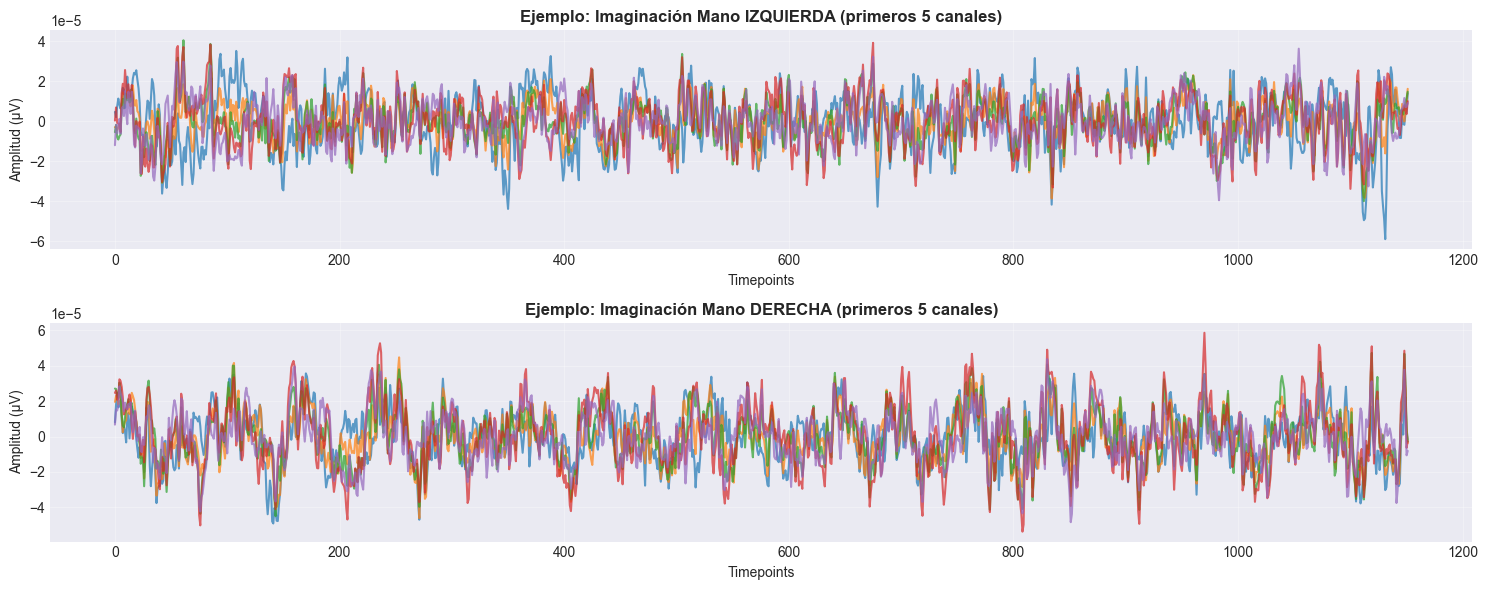

Visualización guardada en: results/deepconvnet/data_examples.png


In [24]:
# Visualizar ejemplo de señal EEG
fig, axes = plt.subplots(2, 1, figsize=(15, 6))

# Ejemplo de Left
left_idx = np.where(y == 0)[0][0]
axes[0].plot(X[left_idx, :5, :].T, alpha=0.7)
axes[0].set_title('Ejemplo: Imaginación Mano IZQUIERDA (primeros 5 canales)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Timepoints')
axes[0].set_ylabel('Amplitud (µV)')
axes[0].grid(True, alpha=0.3)

# Ejemplo de Right
right_idx = np.where(y == 1)[0][0]
axes[1].plot(X[right_idx, :5, :].T, alpha=0.7)
axes[1].set_title('Ejemplo: Imaginación Mano DERECHA (primeros 5 canales)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Timepoints')
axes[1].set_ylabel('Amplitud (µV)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUT_DIR / 'data_examples.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Visualización guardada en: {OUT_DIR / 'data_examples.png'}")

---

# 3. Preprocesamiento

Dividimos los datos y creamos los datasets de PyTorch.

In [25]:
# Split train/val/test (70/15/15)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_SEED, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=RANDOM_SEED, stratify=y_temp
)

print(f"Splits de datos:")
print(f"  Train: {X_train.shape[0]} samples ({X_train.shape[0]/X.shape[0]*100:.1f}%)")
print(f"  Val:   {X_val.shape[0]} samples ({X_val.shape[0]/X.shape[0]*100:.1f}%)")
print(f"  Test:  {X_test.shape[0]} samples ({X_test.shape[0]/X.shape[0]*100:.1f}%)")
print(f"\n  Train balance (Left/Right): {np.bincount(y_train)}")
print(f"  Val balance (Left/Right):   {np.bincount(y_val)}")
print(f"  Test balance (Left/Right):  {np.bincount(y_test)}")

Splits de datos:
  Train: 616 samples (70.0%)
  Val:   132 samples (15.0%)
  Test:  132 samples (15.0%)

  Train balance (Left/Right): [309 307]
  Val balance (Left/Right):   [66 66]
  Test balance (Left/Right):  [67 65]


In [26]:
class EEGDataset(Dataset):
    """Dataset de PyTorch para señales EEG"""
    
    def __init__(self, X, y, normalize=True):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
        
        if normalize:
            # Normalización z-score por canal
            mean = self.X.mean(dim=2, keepdim=True)
            std = self.X.std(dim=2, keepdim=True)
            self.X = (self.X - mean) / (std + 1e-8)
        
        # DeepConvNet espera (N, 1, channels, timepoints)
        self.X = self.X.unsqueeze(1)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Crear datasets
train_dataset = EEGDataset(X_train, y_train, normalize=True)
val_dataset = EEGDataset(X_val, y_val, normalize=True)
test_dataset = EEGDataset(X_test, y_test, normalize=True)

# Crear dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Datasets creados")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches:   {len(val_loader)}")
print(f"  Test batches:  {len(test_loader)}")
print(f"\n  Input shape esperado: (batch, 1, {X.shape[1]}, {X.shape[2]})")

Datasets creados
  Train batches: 39
  Val batches:   9
  Test batches:  9

  Input shape esperado: (batch, 1, 64, 1152)


---

# 4. Arquitectura DeepConvNet

Implementación de DeepConvNet (Schirrmeister et al., 2017)

In [27]:
class DeepConvNet(nn.Module):
    """
    DeepConvNet para clasificación de EEG
    
    Basada en: Schirrmeister et al. (2017)
    "Deep learning with convolutional neural networks for EEG decoding and visualization"
    """
    
    def __init__(self, n_channels=64, n_timepoints=1152, n_classes=2, dropout=0.5):
        super(DeepConvNet, self).__init__()
        
        # Bloque 1: Convolución temporal
        self.conv1 = nn.Conv2d(1, 25, kernel_size=(1, 10), stride=1)
        
        # Bloque 2: Convolución espacial
        self.conv2 = nn.Conv2d(25, 25, kernel_size=(n_channels, 1), stride=1)
        self.bn1 = nn.BatchNorm2d(25)
        self.pool1 = nn.MaxPool2d(kernel_size=(1, 3), stride=(1, 3))
        
        # Bloque 3
        self.conv3 = nn.Conv2d(25, 50, kernel_size=(1, 10), stride=1)
        self.bn2 = nn.BatchNorm2d(50)
        self.pool2 = nn.MaxPool2d(kernel_size=(1, 3), stride=(1, 3))
        
        # Bloque 4
        self.conv4 = nn.Conv2d(50, 100, kernel_size=(1, 10), stride=1)
        self.bn3 = nn.BatchNorm2d(100)
        self.pool3 = nn.MaxPool2d(kernel_size=(1, 3), stride=(1, 3))
        
        # Bloque 5
        self.conv5 = nn.Conv2d(100, 200, kernel_size=(1, 10), stride=1)
        self.bn4 = nn.BatchNorm2d(200)
        self.pool4 = nn.MaxPool2d(kernel_size=(1, 3), stride=(1, 3))
        
        self.dropout = nn.Dropout(dropout)
        self.fc = None  # Se crea dinámicamente
        
    def forward(self, x):
        # Bloque 1: Temporal
        x = self.conv1(x)
        
        # Bloque 2: Espacial
        x = self.conv2(x)
        x = self.bn1(x)
        x = F.elu(x)
        x = self.pool1(x)
        x = self.dropout(x)
        
        # Bloque 3
        x = self.conv3(x)
        x = self.bn2(x)
        x = F.elu(x)
        x = self.pool2(x)
        x = self.dropout(x)
        
        # Bloque 4
        x = self.conv4(x)
        x = self.bn3(x)
        x = F.elu(x)
        x = self.pool3(x)
        x = self.dropout(x)
        
        # Bloque 5
        x = self.conv5(x)
        x = self.bn4(x)
        x = F.elu(x)
        x = self.pool4(x)
        x = self.dropout(x)
        
        # Flatten
        batch_size = x.size(0)
        x = x.view(batch_size, -1)
        
        # Crear FC dinámicamente
        if self.fc is None:
            self.fc = nn.Linear(x.size(1), 2).to(x.device)
        
        x = self.fc(x)
        return x

print("Arquitectura DeepConvNet definida")

Arquitectura DeepConvNet definida


In [28]:
# Crear modelo
n_channels = X.shape[1]
n_timepoints = X.shape[2]

model = DeepConvNet(
    n_channels=n_channels,
    n_timepoints=n_timepoints,
    n_classes=2,
    dropout=DROPOUT
)
model = model.to(DEVICE)

# Contar parámetros
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Modelo DeepConvNet creado")
print(f"  Canales: {n_channels}")
print(f"  Timepoints: {n_timepoints}")
print(f"  Dropout: {DROPOUT}")
print(f"  Parámetros entrenables: aproximadamente {total_params:,}")
print(f"\n{model}")

Modelo DeepConvNet creado
  Canales: 64
  Timepoints: 1152
  Dropout: 0.5
  Parámetros entrenables: aproximadamente 303,900

DeepConvNet(
  (conv1): Conv2d(1, 25, kernel_size=(1, 10), stride=(1, 1))
  (conv2): Conv2d(25, 25, kernel_size=(64, 1), stride=(1, 1))
  (bn1): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(25, 50, kernel_size=(1, 10), stride=(1, 1))
  (bn2): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(50, 100, kernel_size=(1, 10), stride=(1, 1))
  (bn3): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(100, 200, kernel_size=(1, 10), stride=(1

---

# 5. Entrenamiento

Entrenamiento del modelo con early stopping.

In [29]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Entrena una época"""
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    for X_batch, y_batch in dataloader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    
    return avg_loss, accuracy

def validate_epoch(model, dataloader, criterion, device):
    """Valida una época"""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    
    return avg_loss, accuracy, all_preds, all_labels

print("Funciones de entrenamiento definidas")

Funciones de entrenamiento definidas


In [30]:
# Configurar entrenamiento
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Historia de entrenamiento
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

best_val_acc = 0
patience_counter = 0
best_model_path = OUT_DIR / 'best_deepconvnet_model.pth'

print("Iniciando entrenamiento...\n")

Iniciando entrenamiento...



In [31]:
# Loop de entrenamiento
for epoch in range(NUM_EPOCHS):
    # Entrenar
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, DEVICE)
    
    # Validar
    val_loss, val_acc, _, _ = validate_epoch(model, val_loader, criterion, DEVICE)
    
    # Guardar historial
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Imprimir progreso
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    
    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), best_model_path)
        print(f"  [MEJOR MODELO] Guardado con Val Acc: {val_acc:.4f}")
    else:
        patience_counter += 1
        print(f"  [Paciencia: {patience_counter}/{PATIENCE}]")
    
    if patience_counter >= PATIENCE:
        print(f"\nEarly stopping activado en epoch {epoch+1}")
        break
    
    print()

# Cargar mejor modelo
model.load_state_dict(torch.load(best_model_path))
print(f"\nEntrenamiento completado")
print(f"Mejor modelo cargado con Val Acc: {best_val_acc:.4f}")

Epoch 1/50
  Train Loss: 0.7900 | Train Acc: 0.5341
  Val Loss:   0.7443 | Val Acc:   0.4848
  [MEJOR MODELO] Guardado con Val Acc: 0.4848

Epoch 2/50
  Train Loss: 0.8640 | Train Acc: 0.5292
  Val Loss:   0.6941 | Val Acc:   0.5152
  [MEJOR MODELO] Guardado con Val Acc: 0.5152

Epoch 3/50
  Train Loss: 0.8865 | Train Acc: 0.5049
  Val Loss:   0.7151 | Val Acc:   0.4848
  [Paciencia: 1/10]

Epoch 4/50
  Train Loss: 0.8377 | Train Acc: 0.5341
  Val Loss:   0.7128 | Val Acc:   0.5000
  [Paciencia: 2/10]

Epoch 5/50
  Train Loss: 0.8467 | Train Acc: 0.5146
  Val Loss:   0.7034 | Val Acc:   0.5227
  [MEJOR MODELO] Guardado con Val Acc: 0.5227

Epoch 6/50
  Train Loss: 0.8043 | Train Acc: 0.5390
  Val Loss:   0.7237 | Val Acc:   0.5530
  [MEJOR MODELO] Guardado con Val Acc: 0.5530

Epoch 7/50
  Train Loss: 0.7433 | Train Acc: 0.6088
  Val Loss:   0.7117 | Val Acc:   0.5379
  [Paciencia: 1/10]

Epoch 8/50
  Train Loss: 0.7722 | Train Acc: 0.5779
  Val Loss:   0.7244 | Val Acc:   0.5076
  [Pa

---

# 6. Evaluación

Evaluación del modelo en el conjunto de test.

In [32]:
# Evaluar en test set
model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(DEVICE)
        outputs = model(X_batch)
        probs = F.softmax(outputs, dim=1)
        preds = torch.argmax(outputs, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.numpy())
        all_probs.extend(probs.cpu().numpy())

# Calcular métricas
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
cm = confusion_matrix(all_labels, all_preds)

print("\n" + "="*60)
print("RESULTADOS FINALES - DeepConvNet")
print("="*60)
print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print("="*60)

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=['Left', 'Right']))


RESULTADOS FINALES - DeepConvNet
Accuracy:  0.6742 (67.42%)
Precision: 0.6742
Recall:    0.6742
F1-Score:  0.6742

Classification Report:
              precision    recall  f1-score   support

        Left       0.68      0.69      0.68        67
       Right       0.67      0.66      0.67        65

    accuracy                           0.67       132
   macro avg       0.67      0.67      0.67       132
weighted avg       0.67      0.67      0.67       132



In [33]:
# Guardar métricas
metrics = {
    'model': 'DeepConvNet',
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1
}

metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv(OUT_DIR / 'deepconvnet_metrics.csv', index=False)

print(f"Métricas guardadas en: {OUT_DIR / 'deepconvnet_metrics.csv'}")
print("\nMétricas:")
display(metrics_df)

Métricas guardadas en: results/deepconvnet/deepconvnet_metrics.csv

Métricas:


,model,accuracy,precision,recall,f1_score
0,DeepConvNet,0.674242,0.674208,0.674242,0.674186


---

# 7. Visualizaciones

Gráficos de resultados y análisis.

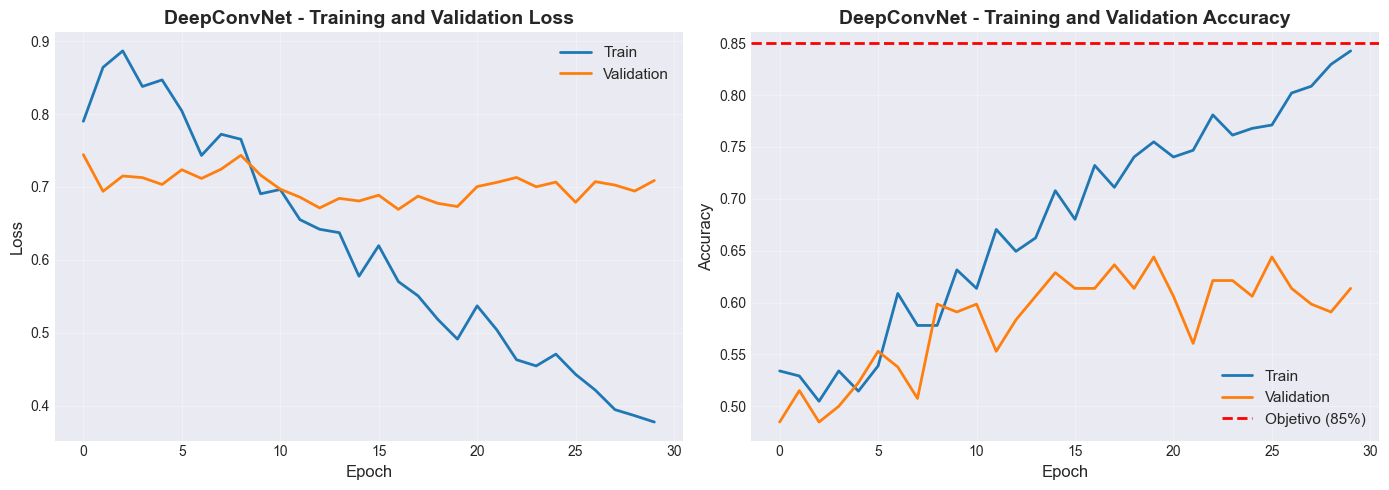

Gráfico guardado en: results/deepconvnet/deepconvnet_training_history.png


In [34]:
# Gráfico de entrenamiento
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train', linewidth=2)
axes[0].plot(history['val_loss'], label='Validation', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('DeepConvNet - Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history['train_acc'], label='Train', linewidth=2)
axes[1].plot(history['val_acc'], label='Validation', linewidth=2)
axes[1].axhline(y=0.85, color='r', linestyle='--', label='Objetivo (85%)', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('DeepConvNet - Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUT_DIR / 'deepconvnet_training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Gráfico guardado en: {OUT_DIR / 'deepconvnet_training_history.png'}")

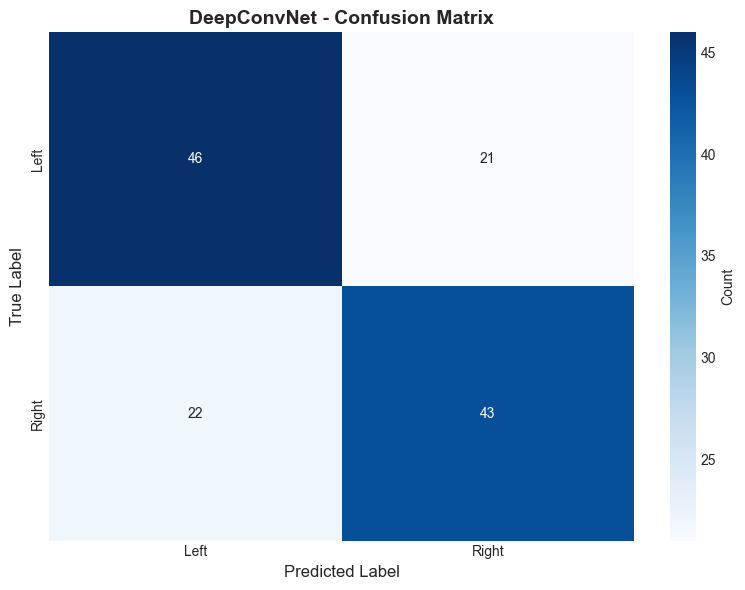

Matriz de confusión guardada en: results/deepconvnet/deepconvnet_confusion_matrix.png


In [35]:
# Matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Left', 'Right'],
            yticklabels=['Left', 'Right'],
            cbar_kws={'label': 'Count'})
plt.title('DeepConvNet - Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig(OUT_DIR / 'deepconvnet_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Matriz de confusión guardada en: {OUT_DIR / 'deepconvnet_confusion_matrix.png'}")

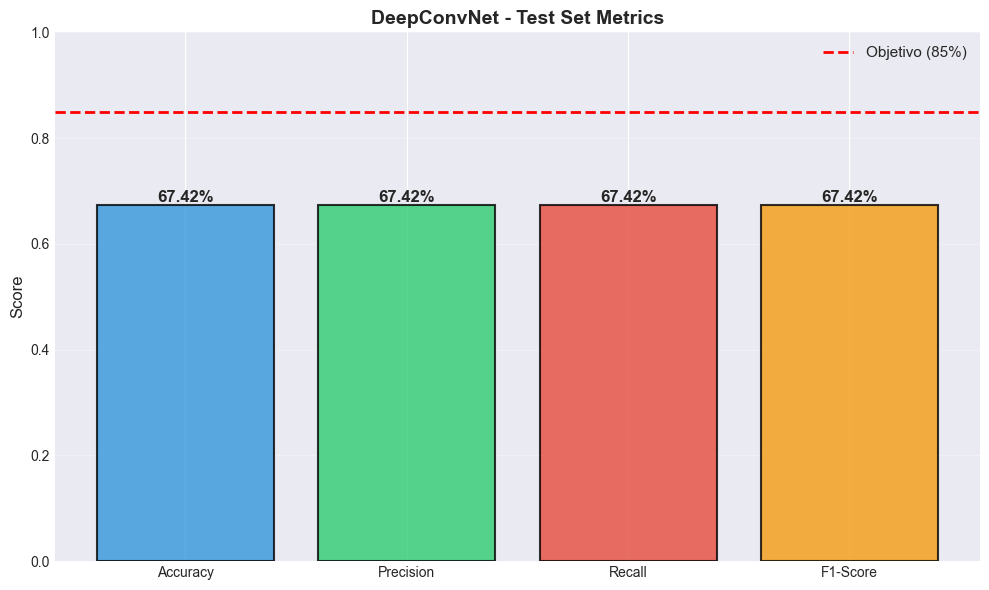

Gráfico de métricas guardado en: results/deepconvnet/deepconvnet_metrics_plot.png


In [36]:
# Gráfico de métricas finales
metrics_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [accuracy, precision, recall, f1]
colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(metrics_plot, values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

# Línea de objetivo
ax.axhline(y=0.85, color='red', linestyle='--', linewidth=2, label='Objetivo (85%)')

# Valores en las barras
for bar, value in zip(bars, values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{value:.2%}', ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('Score', fontsize=12)
ax.set_title('DeepConvNet - Test Set Metrics', fontsize=14, fontweight='bold')
ax.set_ylim([0, 1.0])
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(OUT_DIR / 'deepconvnet_metrics_plot.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Gráfico de métricas guardado en: {OUT_DIR / 'deepconvnet_metrics_plot.png'}")

---

# 8. Conclusiones

Resumen de resultados y siguientes pasos.

In [37]:
# Resumen final
print("\n" + "="*70)
print("RESUMEN FINAL")
print("="*70)
print(f"\nModelo: DeepConvNet (Schirrmeister et al., 2017)")
print(f"Dataset: {X.shape[0]} ensayos, {n_channels} canales, {n_timepoints} timepoints")
print(f"Configuración: LR={LEARNING_RATE}, Dropout={DROPOUT}, Epochs={len(history['train_loss'])}")

print(f"\nRESULTADOS:")
print(f"  Test Accuracy:  {accuracy*100:.2f}%")
print(f"  Test Precision: {precision*100:.2f}%")
print(f"  Test Recall:    {recall*100:.2f}%")
print(f"  Test F1-Score:  {f1*100:.2f}%")

if accuracy >= 0.85:
    print(f"\nOBJETIVO ALCANZADO (>= 85%)")
elif accuracy >= 0.70:
    print(f"\nResultado ACEPTABLE pero por debajo del objetivo (85%)")
    print(f"Sugerencias:")
    print(f"  - Ajustar hiperparámetros (dropout, learning rate)")
    print(f"  - Aumentar epochs")
    print(f"  - Probar data augmentation")
else:
    print(f"\nResultado BAJO (<70%)")
    print(f"Problemas potenciales:")
    print(f"  - Overfitting (Train Acc >> Val Acc)")
    print(f"  - Pocos datos para modelo complejo")
    print(f"  - Preprocesamiento de datos")
    print(f"Recomendaciones:")
    print(f"  - Reducir dropout a 0.2-0.3")
    print(f"  - Probar arquitectura más simple")
    print(f"  - Verificar calidad de datos")

print(f"\nArchivos generados:")
print(f"  - {OUT_DIR / 'best_deepconvnet_model.pth'}")
print(f"  - {OUT_DIR / 'deepconvnet_metrics.csv'}")
print(f"  - {OUT_DIR / 'deepconvnet_training_history.png'}")
print(f"  - {OUT_DIR / 'deepconvnet_confusion_matrix.png'}")
print(f"  - {OUT_DIR / 'deepconvnet_metrics_plot.png'}")
print(f"  - {OUT_DIR / 'data_examples.png'}")

print("\n" + "="*70)
print("Notebook completado exitosamente")
print("="*70)


RESUMEN FINAL

Modelo: DeepConvNet (Schirrmeister et al., 2017)
Dataset: 880 ensayos, 64 canales, 1152 timepoints
Configuración: LR=0.001, Dropout=0.5, Epochs=30

RESULTADOS:
  Test Accuracy:  67.42%
  Test Precision: 67.42%
  Test Recall:    67.42%
  Test F1-Score:  67.42%

Resultado BAJO (<70%)
Problemas potenciales:
  - Overfitting (Train Acc >> Val Acc)
  - Pocos datos para modelo complejo
  - Preprocesamiento de datos
Recomendaciones:
  - Reducir dropout a 0.2-0.3
  - Probar arquitectura más simple
  - Verificar calidad de datos

Archivos generados:
  - results/deepconvnet/best_deepconvnet_model.pth
  - results/deepconvnet/deepconvnet_metrics.csv
  - results/deepconvnet/deepconvnet_training_history.png
  - results/deepconvnet/deepconvnet_confusion_matrix.png
  - results/deepconvnet/deepconvnet_metrics_plot.png
  - results/deepconvnet/data_examples.png

Notebook completado exitosamente


---

## Referencias

1. **Schirrmeister, R. T., et al. (2017)**. *Deep learning with convolutional neural networks for EEG decoding and visualization*. Human brain mapping, 38(11), 5391-5420.

2. **Lawhern, V. J., et al. (2018)**. *EEGNet: a compact convolutional neural network for EEG-based brain–computer interfaces*. Journal of neural engineering, 15(5), 056013.

---

## Próximos Pasos

1. **Si accuracy < 85%**: Ajustar hiperparámetros y volver a entrenar
2. **Comparar** con Bag of Features + SVM
3. **Escribir** sección de resultados en el paper
4. **Analizar** errores del modelo (falsos positivos/negativos)